# How-To: Projects

## User Stories (~19:30 (10min))

#### Idea

> Share tools instead of buying new ones



**Problem**: What are functional requirements to implement a tool-sharing platform?

Note: functional requirements are specifications of what the system should do, what functionality it has. \
For example, a user should be able to create an account, list their tools, and request a tool from another user. \
These are 3 different functional requirements.

**Solution**: User Stories

**User stories** describe *what a user needs and why* (functional requirements from the user’s perspective)

**Examples:**

1. As an owner, I want to list a tool with photos, condition, and availability so others can request it.
1. As a borrower, I want to search/filter tools by type and distance so I can find what I need.
1. As a borrower, I want to request specific dates so availability is clear.

Could you come up with some more?

<details>
<summary> More user stories</summary>
As an owner, I want to accept/decline requests so I stay in control.

As a borrower, I want pickup/drop-off instructions so the handoff is smooth.

As users, I want in-app messaging so we can coordinate.


As an owner, I want to set a deposit and see confirmation so I’m covered.

As users, I want ratings/reviews after return so trust improves.

As an owner, I want to report damage and start a dispute so issues are handled.
</details>

### Sequence Diagram

Note: self-learning topic

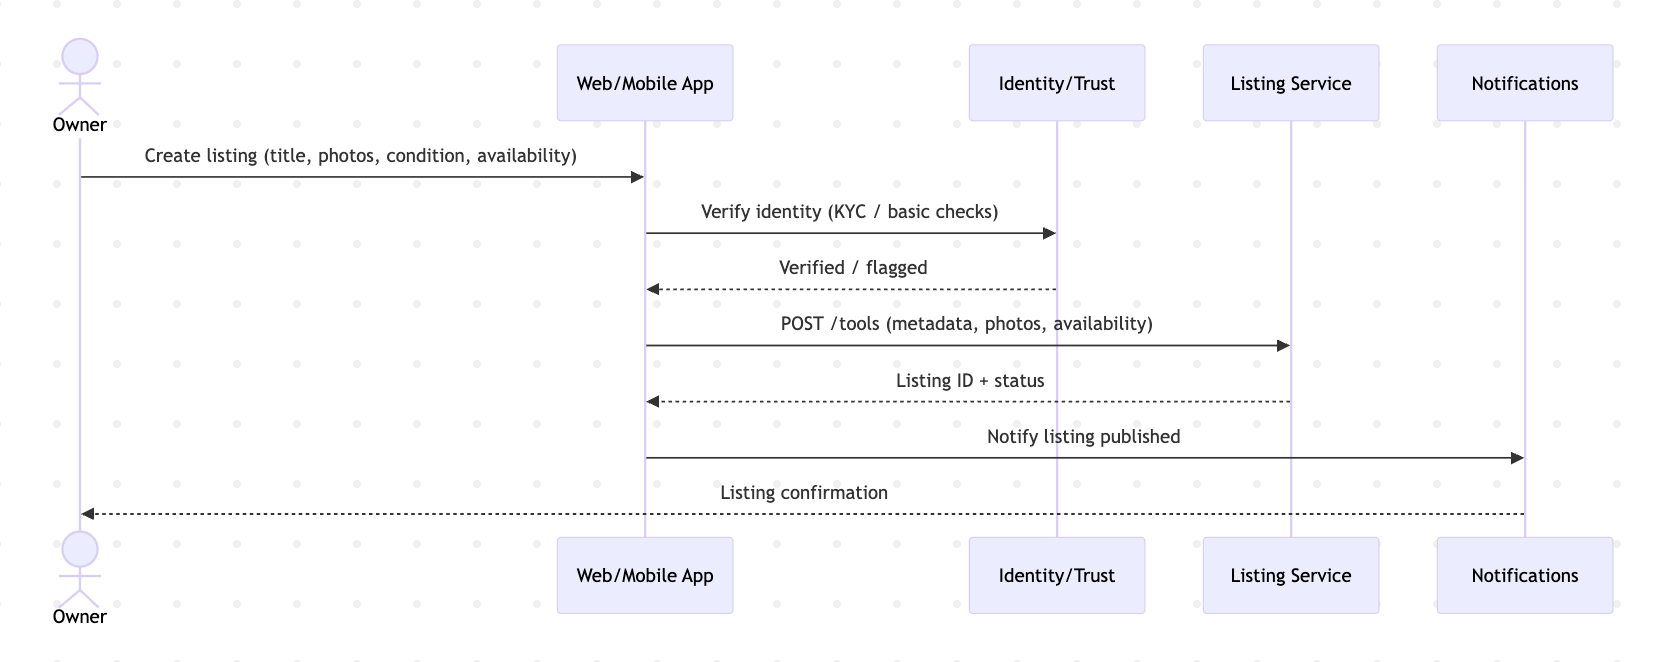

## Architecture (~20:00 (30min))

#### What is Architecture?

* The **high-level organization** of software: how modules, layers, and components are structured and interact.

#### Why Do We Need It?

* **Clarity:** Easier to understand and navigate code.
* **Change & Flexibility:** New features and modifications can be added with minimal disruption.
* **Maintainability:** Code remains reliable and easier to fix or extend over time.
* **Collaboration:** Multiple developers can work without conflicts.
* **Scalability:** Supports growing features and complexity without turning into chaos.

Let's take a look at [mvp](./mvp.md)

**Question:** How do we organize our code?

#### Approach 1: straight-forward

`impl_simple/`

Pros:
* Simple (very simple, in fact) to implement

Cons:
* You can forget about maintainability and flexibility of the project

Works the best when you need to create a temporary application you're sure will not need to be extended or modified in the future.

### N-Tier Architecture

#### What is N-Tier Architecture?

**Definition:** Application is organized into distinct **tiers** (layers) that are **logically separated**, each handling specific responsibilities.

**Key Characteristics:**
- **Horizontal layering** with clear boundaries
- **One-way dependencies** (upper tiers depend on lower tiers)
- **Separation of concerns** across different aspects of the application
- Each tier can be **independently developed, tested, and maintained**

**Common Tiers:**
- **Presentation Tier** - User interface and user experience
- **Business/Logic Tier** - Core application logic and rules
- **Infrastructure Tier** - Implementation of interfaces upon which `Logic Tier` depends
- **Data Tier** - Data storage and persistence



#### BorrowBox N-Tier Example

```text
┌─────────────────────────────────────┐
│        PRESENTATION TIER            │
│   • CLI Interface (input/output)    │
│   • User interaction handling       │
│   • Display formatting             │
└─────────────────────────────────────┘
                    │
┌─────────────────────────────────────┐
│         BUSINESS TIER               │
│   • Tool management logic          │
│   • Search and validation services │
│   • Domain entities (Tool, Contact)│
└─────────────────────────────────────┘
                    │
┌─────────────────────────────────────┐
│          DATA TIER                  │
│   • JSON file storage              │
│   • Data persistence operations    │
│   • Storage abstraction layer      │
└─────────────────────────────────────┘
```

**Flow:** User Input → Business Rules → Data Storage

#### Approach 2: N-Tier Architecture

`impl_n_tier/`

Pros:
* Better separation of concerns
* Flexible and maintainable

Cons:
* More complex to implement
* Frequent overengineering

Works best for small applications that need a bit more structure without being overly complex.

Note: Architectural Styles aren't limited by N-Tier architecture. There are many more (e.g. Microservices, Serverless, Event-Driven)

### Common Mistakes (~20:20 (20min))

#### **Over-Engineering**

**What is it?**
Adding unnecessary complexity or features to code that don’t solve the actual problem.

**Why is it bad?**
* Reduces **clarity**
* Adds **maintenance burden** for code we don’t use

**Example**

In `impl_n_tier/`:

- In `services/search_service.py`: `sort_tools_*` methods aren't used 


#### **Zero Error Handling**

**Why is it bad?**

* Reduces **clarity**: we don't know what edge cases to expect
* Slows **development/collaboration**: one bad case crashes the whole run

In [2]:
%%writefile task_info.txt
op: plus, values: 30 15
op: minus, values: 10 5
action: print, result
op: minus, values: 10 5

Overwriting task_info.txt


In [ ]:
from pathlib import Path

path_to_task_info = "task_info.txt"

def process_batch(path: str):
    # One malformed line or a bug in do_task() will crash the entire batch
    for i, line in enumerate(Path(path).open()):
        task = line.strip()
        do_task(task)             # any exception here stops everything

def do_task(task: str):
    # placeholder real work that might raise
    if "op" not in task:
        raise ValueError("missing op")
    print("Executing task:", task)

process_batch(path_to_task_info)

Executing task: op: plus, values: 30 15
Executing task: op: minus, values: 10 5


ValueError: missing op

#### **Global Mutable State**

**What is it?**
Using module-level or class-level variables that can change at runtime.

**Why is it bad?**

* Injects **implicit dependency** (the outside reader has no idea that some global state is used in your function)
* Hurts **clarity**/**maintainability** (order-dependent bugs, harder tests)

In [5]:
TAX_RATE = 0.20  # mutable global ➜ hidden input

def price_with_tax(amount: float) -> float:
    return round(amount * (1 + TAX_RATE), 2)

def enable_promo():
    global TAX_RATE
    TAX_RATE = 0.10  # elsewhere flips a hidden knob

assert price_with_tax(100) == 120.00  # OK
enable_promo()  # called somewhere else
assert price_with_tax(100) == 120.00  # Fails! 110.00

AssertionError: 

In [ ]:
# better: dependency injection
from dataclasses import dataclass

@dataclass(frozen=True)
class PricingConfig:
    tax_rate: float = 0.20

def price_with_tax(amount: float, cfg: PricingConfig) -> float:
    return round(amount * (1 + cfg.tax_rate), 2)

default_config = PricingConfig()
price_default = price_with_tax(100, default_config)
print(f"{price_default=}")

promo_config = PricingConfig(tax_rate=0.10)
price_promo = price_with_tax(100, promo_config)
print(f"{price_promo=}")

Note: if you have a promo code for taxes, pm me!!!

#### **Mixed Concerns**

**What is it?**
Packing unrelated responsibilities into one place (e.g., business logic + I/O + persistence + presentation). \
In other words, it's violation of **single responsibility principle**.

**Why is it bad?**

* Kills **clarity** (what does this function even do?)
* Blocks **change & flexibility** (small tweaks ripple everywhere)
* Hurts **maintainability**/**collaboration** (tight coupling, merge conflicts)


In [15]:
import sys

def checkout():
    # ❌ Mixed concerns: input parsing + validation + pricing rules + presentation
    raw = input("Enter items as name:price,name:price... > ")
    items = []
    for part in raw.split(","):
        name, price = part.split(":")        # parsing
        price = float(price)                 # validation/conversion
        items.append((name.strip(), price))

    subtotal = sum(p for _, p in items)      # business logic
    total = subtotal * 0.9 if subtotal > 100 else subtotal  # pricing policy

    print("=== Receipt ===")                 # presentation
    for name, p in items:
        print(f"{name:<12} {p:>7.2f}")
    print(f"{'-'*22}\nTOTAL: {total:.2f}")


# apple:1.00,banana:0.50,orange:0.75
checkout()

=== Receipt ===
apple           1.00
banana          0.50
orange          0.75
----------------------
TOTAL: 2.25


In [16]:
# parser.py
def parse_items(s: str):
    items = []
    for part in s.split(","):
        name, price = part.split(":")
        items.append((name.strip(), float(price)))
    return items

# pricing.py
def total(items):
    subtotal = sum(p for _, p in items)
    return subtotal * 0.9 if subtotal > 100 else subtotal

# renderer.py
def render_receipt(items, total_amount):
    lines = ["=== Receipt ==="]
    lines += [f"{name:<12} {p:>7.2f}" for name, p in items]
    lines += ["-"*22, f"TOTAL: {total_amount:.2f}"]
    return "\n".join(lines)


def main():
    raw = input("Enter items as name:price,name:price... > ")
    items = parse_items(raw)
    amount = total(items)
    print(render_receipt(items, amount))


main()

=== Receipt ===
apple           1.00
banana          0.50
orange          0.75
----------------------
TOTAL: 2.25


The best source on good code practices: [refactoring.guru](https://refactoring.guru)

### Cheatsheet

How to do a project:
* Get an idea
* Define functional requirements
* Choose architecture
* Implement